In [3]:
import matplotlib.pyplot as plt
import numpy as np
import phate
import random
import scipy as sp
import scprep
import sys

from sklearn.neighbors import NearestNeighbors


In [189]:
from sklearn.base import BaseEstimator, TransformerMixin


class BranchPointPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, phate_op):
        self.phate_op = phate_op
        self.diff_op = phate_op.diff_op
        self.optimal_t = phate_op.optimal_t
        
        
        self.evals = None
        self.evecs = None
        self.dmap = None

        self.most_distinct_points = None

        self.nn_dist = None
        self.nn_idxs = None
        self.n_nbrs = None
        self.nbrs_dim_est = None
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def get_dmap(self):
        dmap = self.dmap
        if dmap is None:
            dmap = self._calc_dmap()

        return dmap
    
    def _calc_dmap(self, t=None):
        if t is None:
            t = self.optimal_t

        evals, evecs = np.linalg.eig(self.diff_op)
                
        # sort eigenvectors in descending order
        idx = np.abs(evals).argsort()[::-1]
        evals = evals[idx]
        evecs = evecs[:, idx]

        # do diffusion        
        evals = np.power(evals, self.optimal_t)
        evecs = evecs.dot(np.diag(evals))

        self.evals = evals
        self.evecs = evecs
        self.dmap = evecs        
        return evecs
    
    def _calc_num_to_consider(self):
        dmap = self.get_dmap()
        evals = self.evals
        
        # Number of eigenvectors (~ dimensions) to consider.
        dmap_diff = evals - np.roll(evals, 1)
        
        n_evecs = 1
        # Increase the number of eigenvectors until 
        while (dmap_diff[n_evecs + 1] > 2 * dmap_diff[n_evecs]):
            n_evecs += 1
        
        self.n_evecs = n_evecs
        return n_evecs
    

    def get_most_distinct_points(self):
        most_distinct_points = self.most_distinct_points
        if most_distinct_points is None:
            most_distinct_points = self._calc_extrema()
        return most_distinct_points

    

    def _calc_extrema(self):
        return self.__calc_extrema_v2()
        return self.__calc_extrema_v1()
    
    def __calc_extrema_v1(self):
        dmap = self.get_dmap()

        # Ignore first (trivial) eigenvector
        dmap = dmap[:, 1:].copy()

        # Mask lower 50% abs val
        lower_half_abs = np.percentile(np.abs(dmap), 50)
        dmap[np.abs(dmap) < lower_half_abs] = 0

        max_idxs = dmap.argmax(axis=0)
        min_idxs = dmap.argmin(axis=0)
        extrema_idxs = np.unique(np.hstack((max_idxs, min_idxs)))
        self.most_distinct_points = extrema_idxs
        return extrema_idxs

    def __calc_extrema_v2(self):
        # Find the extremas (min and max) of the considered eigenvectors.
        # Keep them in the order of the eigenvalues by weaving min and max values.
        # min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
        # max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
        # combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
        # combined_eigs[0::2] = min_eigs
        # combined_eigs[1::2] = max_eigs

        # Remove duplicates.

        # for e in combined_eigs:
        #     if e not in most_distinct_points:
        #         most_distinct_points.append(e)

        n_consider = self._calc_num_to_consider()
        dmap = self.get_dmap()

        most_distinct_points = []

        # Always skip the first trivial eigenvector
        for i in np.arange(n_consider):
            cur_eigvec = np.copy(dmap[:,i+1])
            # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative 
            # values and vice versa). This part ensures only the extrema on the more significant side is taken.            
            lower_half_abs = np.percentile(np.abs(cur_eigvec), 50)
            cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0

            max_eig = np.argmax(cur_eigvec)
            min_eig = np.argmin(cur_eigvec)

            if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
                most_distinct_points.append(max_eig)
            
            if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
                most_distinct_points.append(min_eig)

        most_distinct_points = np.array(most_distinct_points)
        self.most_distinct_points = most_distinct_points
        return most_distinct_points    

    
    

    def is_landmarked(self):
        import graphtools
        return isinstance(self.phate_op.graph, graphtools.graphs.kNNLandmarkGraph)

    def get_pmn(self):
        # pmn = self.phate_op.graph._data_transitions()
        # original --> landmarks
        pmn = self.phate_op.graph.transitions
        return pmn
    
    def get_pnm(self):
        pnm = self.phate_op.graph._data_transitions()
        # pnm = self.phate_op.graph._landmarks_to_data()
        return pnm

    def _get_full_diff_op_from_landmark_graph(self):
        pmn = self.phate_op.graph._data_transitions()
        pnm = self.phate_op.graph._landmarks_to_data()
        full_diff_op = (pnm @ self.phate_op.diff_op @ pmn)
        return full_diff_op
    
    def _knn_on_diff_op(self):
        # NOTE: using KNN on diff_map is not invertable
        # i.e. need to revert landmark graph here!
        dmap = self.get_dmap()
        #######################
        # INTRINSIC DIMENSION #
        #######################

        # Based on maxLikPointwiseDimEst() of this R package.
        # https://cran.r-project.org/web/packages/intrinsicDimension/README.html

        # Up to 100 dimensions of diffusion maps, 
        # raised to the same power as tdetermined by PHATE.
        dm_dims = min(self.diff_op.shape[1], 100) # NOTE: oroginaly was data.shape[1]
        diff_map = dmap[:,:dm_dims]
        # diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))
        if self.is_landmarked():
            diff_map = self.phate_op.graph.interpolate(diff_map)
    
        # Rank all neighbors in diffusion map coordinates.
        nbrs = NearestNeighbors(
            # n_neighbors=dm_dims,
            n_neighbors=diff_map.shape[0],
            algorithm='ball_tree'
        ).fit(diff_map)

        nn_distances, nn_indices = nbrs.kneighbors(diff_map)
        nn_distances = nn_distances[:, 1:]
        nn_indices = nn_indices[:, 1:]
        self.nn_dist = nn_distances
        self.nn_idxs = nn_indices
        return nn_distances, nn_indices

    def max_likelihood_pointwise_dimensionality_est(self):
        pnm = None
        pmn = None
        if self.is_landmarked():                                
            pnm = self.get_pnm()
            pmn = self.get_pmn()

        n_rows = pmn.shape[0] if pmn is not None else self.diff_op.shape[0]
        if self.nn_dist is None:
            nn_dist, nn_idxs = self._knn_on_diff_op()
        else:
            nn_dist = self.nn_dist
            nn_idxs = self.nn_idxs
        
        most_distinct_points = self.get_most_distinct_points()
        # Maximum Likelihood pointwise dimensionality estimation
        # Hill (1975), Levina and Bickel (2005)
        row_max = np.max(nn_dist, axis=1)
        row_max = row_max.reshape(len(row_max), 1)
        dim_est = np.sum(np.log(row_max / nn_dist), axis=1)

        # Calculate the average dim_est of local neighborhood.
        n_nbrs = min(n_rows // 20, 100)
        nbrs_dim_est = np.average(dim_est[nn_idxs[:, :n_nbrs]], axis=1)
        # nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)

        # Calculate ranking of neighborhood dim_est, from low to high
        temp = nbrs_dim_est.argsort()
        nbrs_dim_est_ranks = np.empty_like(temp)
        nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

        # Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
        low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < n_rows // 2
        most_distinct_points = most_distinct_points[low_dim_est_mask]

        self.most_distinct_points = most_distinct_points
        self.n_nbrs = n_nbrs
        self.nbrs_dim_est = nbrs_dim_est
        return n_nbrs, nbrs_dim_est

    def diffuse_dirac_for_end_points(self):
        if self.n_nbrs is None:
            n_nbrs, nbrs_dim_est = self.max_likelihood_pointwise_dimensionality_est()
        else:
            n_nbrs = self.n_nbrs        
            nbrs_dim_est = self.nbrs_dim_est
            
        most_distinct_points = self.get_most_distinct_points()

        ##################################
        # DIFFUSING DIRAC FOR END POINTS #
        ##################################
        pnm = None
        pmn = None
        opt_t = self.optimal_t
        nn_idxs = self.nn_idxs
        if self.is_landmarked():                                
            pnm = self.get_pnm()
            pmn = self.get_pmn()

        n_rows = pmn.shape[0] if pmn is not None else self.diff_op.shape[0]

        branch_points = []
        classes = np.zeros(n_rows, dtype="int32") # NOTE: original was data
        classes_value = np.repeat(-float('inf'), n_rows)
        for end_point_index in np.arange(most_distinct_points.size):
            cur_end_point = most_distinct_points[end_point_index]
                        
            if self.is_landmarked():
                undo_diff = (pmn @ self.diff_op @ pnm)
                diff_op_t = np.linalg.matrix_power(undo_diff, opt_t)
            else:
                diff_op_t = np.linalg.matrix_power(self.diff_op, opt_t)            

            branch_point_dim_est_avg_cache = -float('inf')

            for it in range(20):
                branch_from_end_point = diff_op_t[:, cur_end_point]

                branch_max = np.max(branch_from_end_point)
                branch_min = np.min(branch_from_end_point)
                
                branch_threshold = branch_min + (branch_max - branch_min) * 0.1
                
                deviation_from_branch_threshold = branch_from_end_point - branch_threshold
                deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = float('inf')

                cur_branch_point = deviation_from_branch_threshold.argmin()
                potential_branch_points = np.argpartition(deviation_from_branch_threshold, 20)[:20]
                
                branch_point_dim_est_avg = np.average(nbrs_dim_est[potential_branch_points])
                if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
                    break
                branch_point_dim_est_avg_cache = branch_point_dim_est_avg
                
                
                if self.is_landmarked():                                
                    undo_diff = (pmn @ self.diff_op @ pnm)
                    diff_op_t = diff_op_t.dot(undo_diff)
                else:
                    diff_op_t = diff_op_t.dot(self.diff_op)



            branch_points.append(cur_branch_point)
            on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
            color = diff_op_t[:, cur_end_point]

            on_branch_mask[color < classes_value] = 0

            color[np.logical_not(on_branch_mask)] = -np.max(color)

            classes_value[on_branch_mask] = color[on_branch_mask]
            classes[on_branch_mask] = end_point_index + 1

        #####################
        # REMOVE DUPLICATES #
        #####################
        # We want to remove branch points that are too close together.

        branch_points = np.array(branch_points)
        branch_point_nbrs = nn_idxs[branch_points,:n_nbrs]
        branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
        center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
        neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
        branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))


        # For each pair of branch_points, keep only the one with higher eigenvalue.
        # (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
        # to the first point of each pair.)
        points_to_exclude = []
        for pair in branch_point_pairs:
            if pair[0] not in points_to_exclude:
                points_to_exclude.append(pair[1])

        branch_points = np.delete(
            branch_points, 
            np.argwhere(np.isin(branch_points, points_to_exclude))
        )
        self.classes = classes
        self.branch_points = branch_points
        return branch_points
    
    def plot_branchs(self, emb):
        most_distinct_points = self.most_distinct_points
        branch_points = self.branch_points
        # Plot by class with end points and branch points
        classes = self.classes
        if classes is None:            
            classes = ['u' for e in emb]

        ax = scprep.plot.scatter2d(emb, c=classes)
        plot_numbers = np.repeat("", emb.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        plot_numbers[branch_points] = "*"
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
        
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (emb[i][0], emb[i][1]), size=15, bbox=bbox_props)


    def assign_branches(self):
        ###################
        # ASSIGN BRANCHES #
        ###################
        dmap = self.get_dmap()
        most_distinct_points = self.most_distinct_points

        # Find coordinates between every point and every MDP.
        all_dm_coords = dmap
        mdp_dm_coords = dmap[most_distinct_points,:]
        pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

        # For every point, rank MDPs by increasing distance.
        s = np.argsort(pairwise_dist, axis=1)
        i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
        j = np.arange(pairwise_dist.shape[1])
        
        mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
        mdp_ranking[i, s] = j + 1

        # Assign every point to the branch between its two most highly ranked MDPs.
        mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
        mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
        
        branch_classes = list(zip(mdp_1, mdp_2))
        branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
        
        ax = scprep.plot.scatter2d(data_ph, c=branch_classes)
        
        plot_numbers = np.repeat("", data_ph.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

        # sys.stdout = open('trash', 'w')
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)    

In [190]:
bpp = BranchPointPredictor(phate_op)

In [191]:
bpp.diffuse_dirac_for_end_points()

array([ 609, 1514, 1240])

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


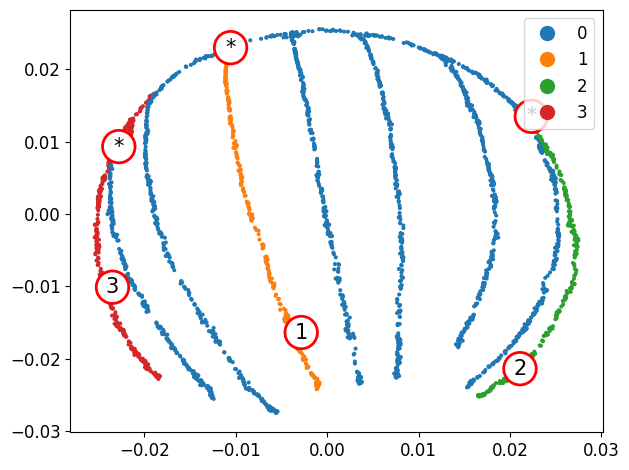

In [192]:
bpp.plot_branchs(data_ph)

In [111]:
tree, branches = phate.tree.gen_dla(
    n_dim = 200, n_branch = 10, branch_length = 300, rand_multiplier = 2, seed=37, sigma = 5
)
print(tree.shape, branches.shape)

(3000, 200) (3000,)


In [5]:
data = tree
data.shape

(3000, 200)

In [6]:
phate_op = phate.PHATE()
data_ph = phate_op.fit_transform(tree)

Calculating PHATE...
  Running PHATE on 3000 observations and 200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.80 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.30 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.64 seconds.
  Calculated landmark operator in 4.75 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 3.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.25 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 16.90 seconds.
Calculated PHATE in 27.72 seconds.


/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


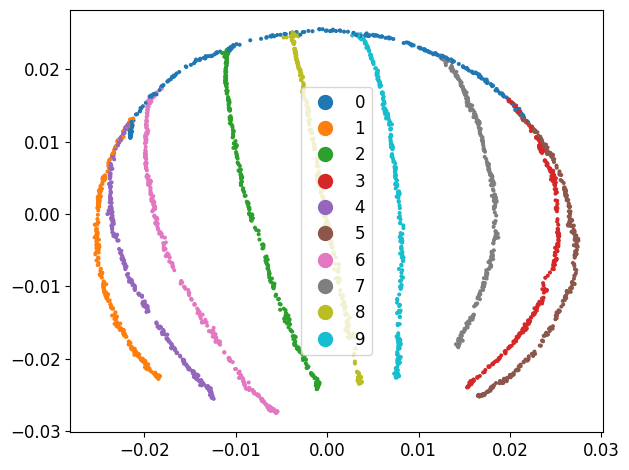

In [9]:
ax = scprep.plot.scatter2d(data_ph, c=branches)

In [124]:
################
# DISTINCTNESS #
################
# Find and sort eigenvectors and eigenvalues of diffusion operators. 
phate_op_eigvals, phate_op_eigvecs = np.linalg.eig(phate_op.diff_op)
idx = np.abs(phate_op_eigvals).argsort()[::-1]
phate_op_eigvals = phate_op_eigvals[idx]
phate_op_eigvecs = phate_op_eigvecs[:, idx]
phate_op_eigvals = np.power(phate_op_eigvals, phate_op.optimal_t)
phate_op_eigvecs = phate_op_eigvecs.dot(np.diag(phate_op_eigvals))

# Number of eigenvectors (~ dimensions) to consider.
phate_op_eigvals_diff = phate_op_eigvals - np.roll(phate_op_eigvals, 1)
n_eigvecs = 1

In [125]:
# Increase the number of eigenvectors until 
while (phate_op_eigvals_diff[n_eigvecs + 1] > 2 * phate_op_eigvals_diff[n_eigvecs]):
  n_eigvecs += 1
  
n_eigvecs

4

In [161]:
bpp.n_evecs

4

In [127]:
# Find the extremas (min and max) of the considered eigenvectors.
# Keep them in the order of the eigenvalues by weaving min and max values.
# min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
# max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
# combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
# combined_eigs[0::2] = min_eigs
# combined_eigs[1::2] = max_eigs

# Remove duplicates.

# for e in combined_eigs:
#     if e not in most_distinct_points:
#         most_distinct_points.append(e)

most_distinct_points = []

# Always skip the first trivial eigenvector
for i in np.arange(n_eigvecs):
  cur_eigvec = np.copy(phate_op_eigvecs[:,i+1])
  # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative values and vice versa). This part ensures only the extrema on the more significant side is taken.
  lower_half_abs = np.percentile(np.abs(cur_eigvec), 50)
  cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0
  max_eig = np.argmax(cur_eigvec)
  min_eig = np.argmin(cur_eigvec)
  if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
    most_distinct_points.append(max_eig)
  if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
    most_distinct_points.append(min_eig)

most_distinct_points = np.array(most_distinct_points)

In [128]:
most_distinct_points#, distinct

array([1801, 1624,  830, 1741,  476,  290])

In [163]:
most_distinct_points1

array([1801, 1624,  830, 1741,  476,  290])

In [162]:
most_distinct_points1 = []

# Always skip the first trivial eigenvector
for i in np.arange(4):
  cur_eigvec = np.copy(bpp.dmap[:,i+1])
  # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative values and vice versa). This part ensures only the extrema on the more significant side is taken.
  lower_half_abs = np.percentile(np.abs(cur_eigvec), 50)
  cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0
  max_eig = np.argmax(cur_eigvec)
  min_eig = np.argmin(cur_eigvec)
  if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points1:
    most_distinct_points1.append(max_eig)
  if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points1:
    most_distinct_points1.append(min_eig)

most_distinct_points1 = np.array(most_distinct_points1)

In [157]:
bpp.dmap.shape

(1842, 1842)

In [160]:
np.all(phate_op_eigvecs == bpp.dmap)

True

In [130]:
# These extremas could contain branch points but 
# We will classify them based on their intrinsic dimensionality.

#######################
# INTRINSIC DIMENSION #
#######################

# Based on maxLikPointwiseDimEst() of this R package.
# https://cran.r-project.org/web/packages/intrinsicDimension/README.html

# Up to 100 dimensions of diffusion maps, 
# raised to the same power as tdetermined by PHATE.
dm_dims = min(data.shape[1], 100)
diff_map = phate_op_eigvecs[:,:dm_dims]
# diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))

In [165]:
bpp.is_landmarked()

True

In [132]:
diff_map = phate_op.graph.interpolate(diff_map)


# Rank all neighbors in diffusion map coordinates.
nbrs = NearestNeighbors(
  # n_neighbors=dm_dims,
  n_neighbors=diff_map.shape[0],
  algorithm='ball_tree'
  ).fit(diff_map)
nn_distances, nn_indices = nbrs.kneighbors(diff_map)
nn_distances = nn_distances[:,1:]
nn_indices = nn_indices[:,1:]

In [167]:
np.all(nn_distances==bpp.nn_dist)

True

In [134]:
nn_indices

array([[   1,    9, 1510, ..., 2698, 2696, 2695],
       [1502,    0,    9, ..., 2698, 2696, 2695],
       [   3, 1508,   12, ..., 2698, 2696, 2695],
       ...,
       [2987, 2993, 2991, ..., 2698, 2696, 2695],
       [2990, 2992, 2989, ..., 2698, 2696, 2695],
       [2995, 2988, 2985, ..., 2698, 2696, 2695]])

In [172]:
n_rows = bpp.get_pmn().shape[0] if pmn is not None else self.diff_op.shape[0]
n_rows

3000

In [173]:
data.shape[0]

3000

In [135]:
# NOTE: using KNN on diff_map is not invertable
# phate_op.graph.interpolate(nn_indices).max()

In [136]:
# Maximum Likelihood pointwise dimensionality estimation
# Hill (1975), Levina and Bickel (2005)
row_max = np.max(nn_distances, axis=1)
row_max = row_max.reshape(len(row_max), 1)
dim_est = np.sum(np.log(row_max / nn_distances), axis=1)

# Calculate the average dim_est of local neighborhood.
n_nbrs = min(data.shape[0] // 20, 100)
nbrs_dim_est = np.average(dim_est[nn_indices[:,:n_nbrs]], axis=1)

# nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)






# Calculate ranking of neighborhood dim_est, from low to high
temp = nbrs_dim_est.argsort()
nbrs_dim_est_ranks = np.empty_like(temp)
nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

# Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
most_distinct_points = most_distinct_points[low_dim_est_mask]

In [174]:
most_distinct_points

array([ 830, 1741,  476])

In [175]:
bpp.most_distinct_points

array([ 830, 1741,  476])

In [138]:
pmn = phate_op.graph._data_transitions()
pmn.shape

(1842, 3000)

In [139]:
pnm = phate_op.graph._transitions
pnm.shape

(3000, 1842)

In [178]:
np.all(bpp.get_pnm().todense() == pmn)

True

In [180]:
bpp.get_pmn().shape[0] if pmn is not None else self.diff_op.shape[0]

3000

In [183]:
most_distinct_points

array([ 830, 1741,  476])

In [184]:
bpp.most_distinct_points

array([ 830, 1741,  476])

In [188]:
np.all(nbrs_dim_est == bpp.nbrs_dim_est)

True

In [181]:
##################################
# DIFFUSING DIRAC FOR END POINTS #
##################################

branch_points = []
classes = np.zeros(data.shape[0], dtype="int32")
classes_value = np.repeat(-float('inf'), data.shape[0])
for end_point_index in np.arange(most_distinct_points.size):
  cur_end_point = most_distinct_points[end_point_index]
  
  # undo_diff = (phate_op.graph.interpolate(phate_op.diff_op) @ phate_op.graph._landmarks_to_data())
  undo_diff = (pnm @ phate_op.diff_op @ pmn)
  diff_op_t = np.linalg.matrix_power(
    undo_diff, 
    phate_op.optimal_t
  )
  # diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)
  # break

  # diff_op_t = phate_op.graph.interpolate(diff_op_t)
  # diff_op_t = (phate_op.graph.transitions @ diff_op_t)


  branch_point_dim_est_avg_cache = -float('inf')
  for it in range(20):
    branch_from_end_point = diff_op_t[:,cur_end_point]
    branch_max = np.max(branch_from_end_point)
    branch_min = np.min(branch_from_end_point)
    branch_threshold = branch_min + (branch_max - branch_min) * 0.1
    deviation_from_branch_threshold = \
      branch_from_end_point - branch_threshold
    deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = \
      float('inf')
    cur_branch_point = deviation_from_branch_threshold.argmin()
    potential_branch_points = \
      np.argpartition(deviation_from_branch_threshold, 20)[:20]
    branch_point_dim_est_avg = \
      np.average(nbrs_dim_est[potential_branch_points])
    if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
      break
    branch_point_dim_est_avg_cache = branch_point_dim_est_avg
    
    # diff_op_t = diff_op_t.dot(phate_op.diff_op)
    # undo_diff = (phate_op.graph.interpolate(phate_op.diff_op) @ phate_op.graph._landmarks_to_data())
    undo_diff = (pnm @ phate_op.diff_op @ pmn)
    diff_op_t = diff_op_t.dot(
        undo_diff    
      )


  branch_points.append(cur_branch_point)
  on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
  color = diff_op_t[:,cur_end_point]
  on_branch_mask[color < classes_value] = 0
  color[np.logical_not(on_branch_mask)] = -np.max(color)
  classes_value[on_branch_mask] = color[on_branch_mask]
  classes[on_branch_mask] = end_point_index + 1
  # ax = scprep.plot.scatter2d(data_ph, c=color)
  # plot_numbers = np.repeat("", data_ph.shape[0])
  # plot_numbers[cur_end_point] = 'e'
  # plot_numbers[cur_branch_point] = 'b'
  # bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
  # sys.stdout = open('trash', 'w')
  # for i, txt in enumerate(plot_numbers):
  #   ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)
  # sys.stdout = sys.__stdout__

In [182]:
np.all(classes == bpp.classes)

False

In [141]:
#####################
# REMOVE DUPLICATES #
#####################
# We want to remove branch points that are too close together.

branch_points = np.array(branch_points)
branch_point_nbrs = nn_indices[branch_points,:n_nbrs]
branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

In [142]:
# For each pair of branch_points, keep only the one with higher eigenvalue.
# (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
# to the first point of each pair.)
points_to_exclude = []
for pair in branch_point_pairs:
  if pair[0] not in points_to_exclude:
    points_to_exclude.append(pair[1])

branch_points = np.delete(branch_points,
  np.argwhere(np.isin(branch_points, points_to_exclude)))

In [143]:
branch_points

array([ 609, 1514, 1240])

In [144]:
bpp.branch_points

array([254])

In [93]:
np.where((bpp.classes == classes) == False)

(array([  26,   28,  249,  250,  251,  252,  253,  254,  255,  256,  257,
         258,  259,  260,  261,  262,  263,  264,  265,  266,  267,  268,
         269,  270,  271,  272,  273,  274,  275,  276,  277,  278,  279,
         280,  281,  282,  283,  284,  285,  286,  287,  288,  289,  290,
         291,  292,  293,  294,  295,  296,  297,  298,  299,  300,  301,
         302,  303,  304,  305,  306,  307,  308,  309,  310,  311,  312,
         313,  314,  315,  316,  317,  318,  319,  320,  321,  322,  323,
         324,  325,  326,  327,  328,  329,  330,  331,  332,  333,  334,
         335,  336,  337,  338,  339,  340,  341,  342,  343,  344,  345,
         346,  347,  348,  349,  350,  351,  352,  353,  354,  355,  356,
         357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
         368,  369,  370,  371,  372,  373,  374,  375,  376,  377,  378,
         379,  380,  381,  382,  383,  384,  385,  386,  387,  388,  389,
         390,  391,  392,  393,  394, 

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


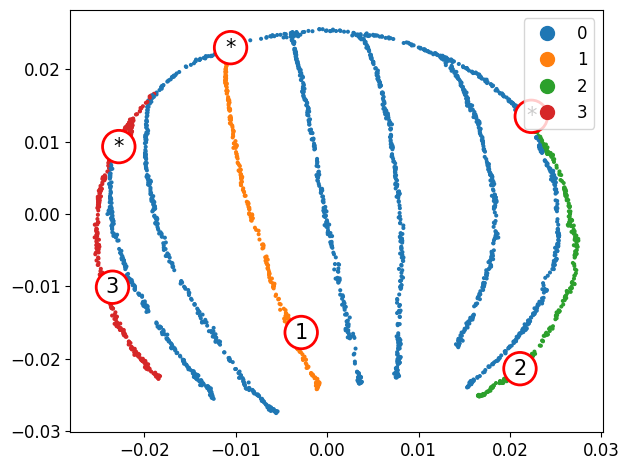

In [48]:
# Plot by class with end points and branch points
ax = scprep.plot.scatter2d(data_ph, c=classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
plot_numbers[branch_points] = "*"
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)


In [226]:
colors = phate_op.graph.interpolate(phate_op_eigvecs[:,eigvec_index])

In [175]:
colors.min(), colors.max()

(-0.03460440265540042, 0.03158497574906776)

In [179]:
pairwise_dist = sp.spatial.distance.cdist(colors.reshape(-1, 1), colors.reshape(-1, 1))

In [182]:
import seaborn as sns

In [184]:
pairwise_dist.min(), pairwise_dist.max()


(0.0, 0.06618937840446817)

<Axes: >

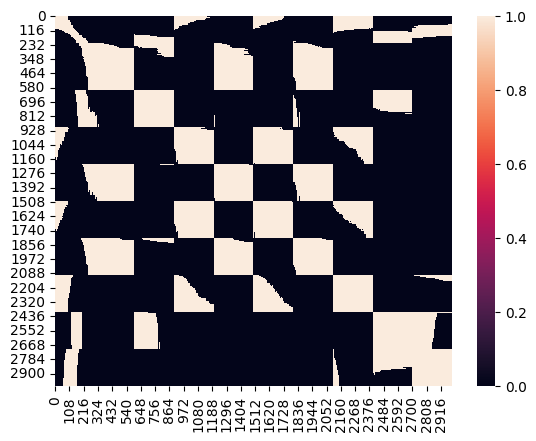

In [187]:
sns.heatmap((pairwise_dist < 0.01).astype(int))

<Axes: >

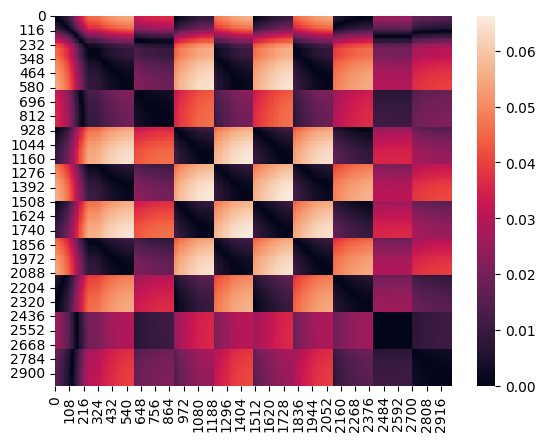

In [183]:
sns.heatmap(pairwise_dist)

In [53]:
size = np.ones(data.shape[0])
size[np.argmax(phate_op_eigvecs[:,eigvec_index])] = 50
size[np.argmin(phate_op_eigvecs[:,eigvec_index])] = 50
np.unique(size, return_counts=True)

(array([ 1., 50.]), array([1198,    2]))

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


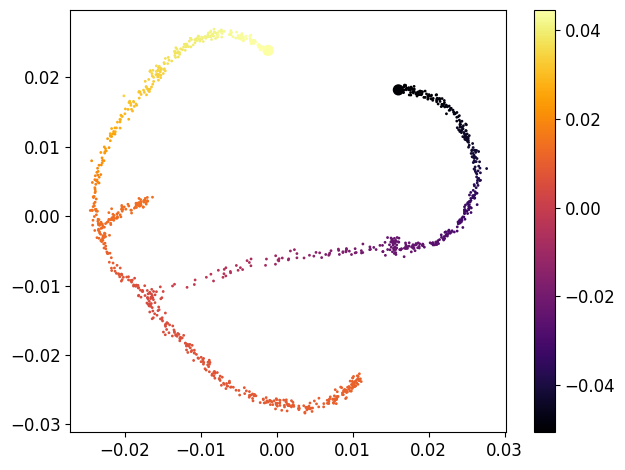

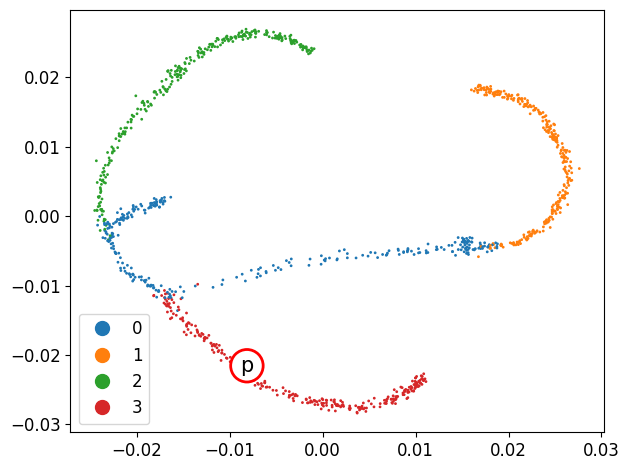

In [48]:
# Plot by an eigenvector
eigvec_index = 1
size = np.ones(data.shape[0])
size[np.argmax(phate_op_eigvecs[:,eigvec_index])] = 50
size[np.argmin(phate_op_eigvecs[:,eigvec_index])] = 50
scprep.plot.scatter2d(data_ph, c=
                      phate_op_eigvecs[:,eigvec_index], 
                      # phate_op.graph.transitions @ phate_op_eigvecs[:,eigvec_index],
                      # phate_op.graph.interpolate(phate_op_eigvecs[:,eigvec_index]), 
                      s=size)

# Plot one point
point_index = 1000
size = np.ones(data.shape[0])
size[point_index]
ax = scprep.plot.scatter2d(data_ph, c=branches, s=size)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[point_index] = "p"
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


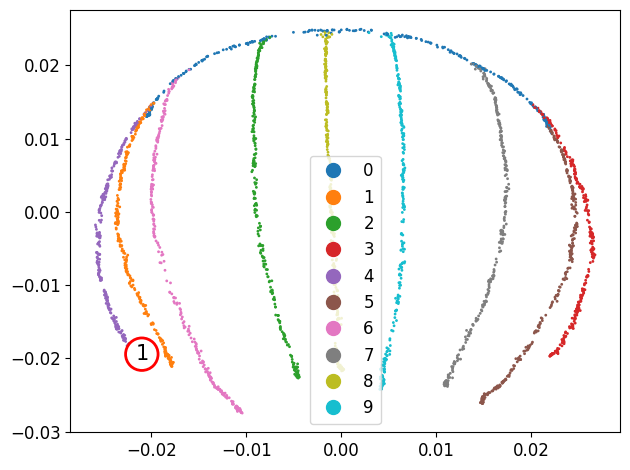

In [228]:
# Based on most distinct indices.
size = np.ones(data.shape[0])
size[most_distinct_points] = 50
ax = scprep.plot.scatter2d(data_ph, c=branches, s=size)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: >

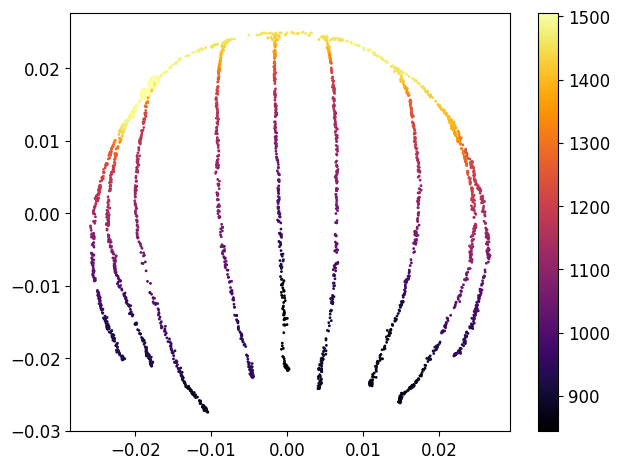

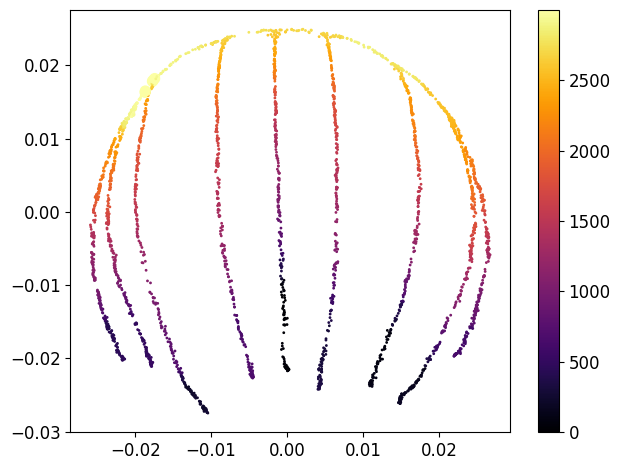

In [229]:
# Based on intrinsic dimensionality.
highest_nbrs_dim_est = nbrs_dim_est.argsort()[-5:]
size = np.ones(data.shape[0])
size[highest_nbrs_dim_est] = 50
scprep.plot.scatter2d(data_ph, c=nbrs_dim_est, s=size)

# Based on ranking of intrinsic dimensionality
scprep.plot.scatter2d(data_ph, c=nbrs_dim_est_ranks, s=size)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: >

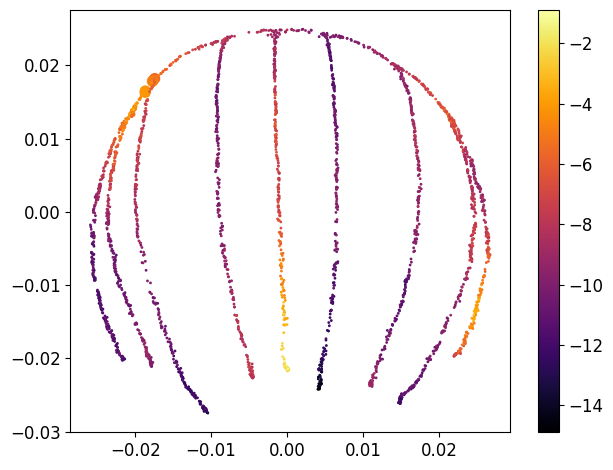

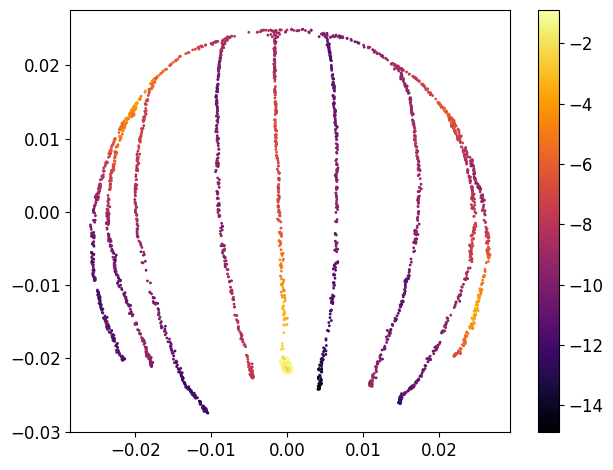

In [98]:
##############
# CENTRALITY #
##############

def _power_iteration(A, num_simulations):
  # Ideally choose a random vector
  # To decrease the chance that our vector
  # Is orthogonal to the eigenvector
  b_k = np.random.rand(A.shape[1])
  b_k = b_k[:, np.newaxis]
  for _ in range(num_simulations):
    # calculate the matrix-by-vector product Ab
    b_k1 = np.dot(A, b_k)
    # calculate the norm
    b_k1_norm = np.linalg.norm(b_k1)
    # re normalize the vector
    b_k = b_k1 / b_k1_norm
  return b_k

kernel = phate_op.graph.kernel
centrality = _power_iteration(kernel.todense(), 100)
scprep.plot.scatter2d(data_ph, c=np.log(centrality), s=size)

most_central_nn_indices = (-centrality).flatten().argsort()[0,:5].tolist()[0]

size = np.ones(data.shape[0])
size[most_central_nn_indices] = 50
scprep.plot.scatter2d(data_ph, c=np.log(centrality), s=size)


In [108]:
mdp_ranking

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


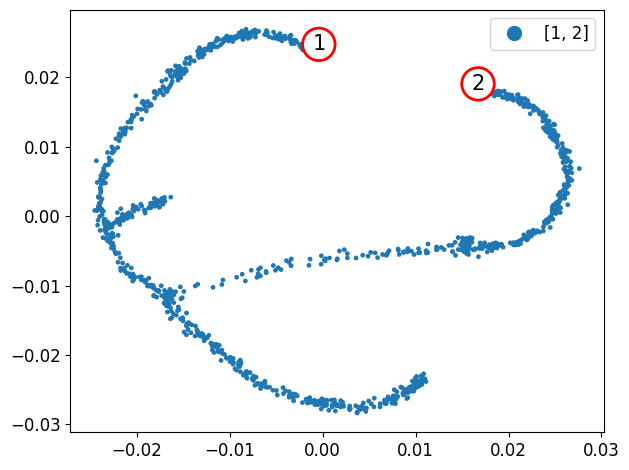

In [54]:
###################
# ASSIGN BRANCHES #
###################

# Find coordinates between every point and every MDP.
all_dm_coords = diff_map
mdp_dm_coords = diff_map[most_distinct_points,:]
pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

# For every point, rank MDPs by increasing distance.
s = np.argsort(pairwise_dist, axis=1)
i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
j = np.arange(pairwise_dist.shape[1])
mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
mdp_ranking[i, s] = j + 1

# Assign every point to the branch between its two most highly ranked MDPs.
mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
branch_classes = list(zip(mdp_1, mdp_2))
branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
ax = scprep.plot.scatter2d(data_ph, c=branch_classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.55216007e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.52899201e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.84146691e-02],
       ...,
       [0.00000000e+00, 8.90141501e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [112]:

#################
# DELTA DIM EST #
#################

diff_op_1 = phate_op.diff_op
diff_op_1 = phate_op.graph.interpolate(diff_op_1)
diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)
delta_dim_est = np.abs(diff_op_1.dot(dim_est) - diff_op_t.dot(dim_est))
scprep.plot.scatter2d(data_ph, c=delta_dim_est, s=size)

ValueError: shapes (3000,1842) and (3000,) not aligned: 1842 (dim 1) != 3000 (dim 0)

# attempt to wranle original

In [28]:
# Rank all neighbors in diffusion map coordinates.
nbrs = NearestNeighbors(
  # n_neighbors=dm_dims,
  n_neighbors=diff_map.shape[0],
  algorithm='ball_tree'
  ).fit(diff_map)
nn_distances, nn_indices = nbrs.kneighbors(diff_map)
nn_distances = nn_distances[:,1:]
nn_indices = nn_indices[:,1:]

In [56]:
# Maximum Likelihood pointwise dimensionality estimation
# Hill (1975), Levina and Bickel (2005)
row_max = np.max(nn_distances, axis=1)
row_max = row_max.reshape(len(row_max), 1)
dim_est = np.sum(np.log(row_max / nn_distances), axis=1)

# Calculate the average dim_est of local neighborhood.
n_nbrs = min(data.shape[0] // 20, 100)
nbrs_dim_est = np.average(dim_est[nn_indices[:,:n_nbrs]], axis=1)






nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)






# Calculate ranking of neighborhood dim_est, from low to high
temp = nbrs_dim_est.argsort()
nbrs_dim_est_ranks = np.empty_like(temp)
nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

# Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
most_distinct_points = most_distinct_points[low_dim_est_mask]

In [57]:
##################################
# DIFFUSING DIRAC FOR END POINTS #
##################################

branch_points = []
classes = np.zeros(data.shape[0], dtype="int32")
classes_value = np.repeat(-float('inf'), data.shape[0])
for end_point_index in np.arange(most_distinct_points.size):
  cur_end_point = most_distinct_points[end_point_index]
  diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)


  diff_op_t = phate_op.graph.interpolate(diff_op_t)


  branch_point_dim_est_avg_cache = -float('inf')
  for it in range(20):
    branch_from_end_point = diff_op_t[:,cur_end_point]
    branch_max = np.max(branch_from_end_point)
    branch_min = np.min(branch_from_end_point)
    branch_threshold = branch_min + (branch_max - branch_min) * 0.2
    deviation_from_branch_threshold = \
      branch_from_end_point - branch_threshold
    deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = \
      float('inf')
    cur_branch_point = deviation_from_branch_threshold.argmin()
    potential_branch_points = \
      np.argpartition(deviation_from_branch_threshold, 20)[:20]
    branch_point_dim_est_avg = \
      np.average(nbrs_dim_est[potential_branch_points])
    if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
      break
    branch_point_dim_est_avg_cache = branch_point_dim_est_avg
    diff_op_t = diff_op_t.dot(phate_op.diff_op)
  branch_points.append(cur_branch_point)
  on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
  color = diff_op_t[:,cur_end_point]
  on_branch_mask[color < classes_value] = 0
  color[np.logical_not(on_branch_mask)] = -np.max(color)
  classes_value[on_branch_mask] = color[on_branch_mask]
  classes[on_branch_mask] = end_point_index + 1
  # ax = scprep.plot.scatter2d(data_ph, c=color)
  # plot_numbers = np.repeat("", data_ph.shape[0])
  # plot_numbers[cur_end_point] = 'e'
  # plot_numbers[cur_branch_point] = 'b'
  # bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
  # sys.stdout = open('trash', 'w')
  # for i, txt in enumerate(plot_numbers):
  #   ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)
  # sys.stdout = sys.__stdout__

In [58]:
#####################
# REMOVE DUPLICATES #
#####################
# We want to remove branch points that are too close together.

branch_points = np.array(branch_points)
branch_point_nbrs = nn_indices[branch_points,:n_nbrs]
branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

IndexError: index 1931 is out of bounds for axis 0 with size 1842

In [ ]:
transform = None # input data
transitions = phate_op.graph.transitions
Y = None


Y_transform = transitions.dot(transform)

In [65]:
phate_op.graph.interpolate(nn_indices)

1841

In [60]:
nn_indices.shape

(1842, 1841)

In [41]:
phate_op.graph.landmark_op.shape

(1842, 1842)

In [42]:
phate_op.graph.data_nu.shape

(3000, 100)

In [79]:
phate_op.graph.landmark_op.dot(nn_indices)

0.0